In [1]:
import pandas as pd
import numpy as np
import itertools
from matplotlib import pyplot as plt
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.graphics.factorplots import interaction_plot
from sklearn.linear_model import LinearRegression

# 通気層の等価温度、通気層を考慮した壁体の相当熱貫流率補正係数の検証
## 分析用データの読み込み

In [2]:
# CSVファイルを読み込む
df = pd.read_csv('wall_status_data_frame.csv', index_col=0)

# 温度差の列を追加
df["delta_theta_as_e-theta_r"] = df["theta_as_e"] - df["theta_r"]
df["delta_theta_sat-theta_r"] = df["theta_sat"] - df["theta_r"]

# 問題のありそうな計算結果を抽出したCSVファイルを出力
# 収束しなかった場合のデータ
df.query("is_optimize_succeed != True").to_csv("wall_status_optimize_failed.csv")
# k_eが2より大きくなる場合のデータ
df.query("k_e > 2.0  ").to_csv("wall_status_k_e_over_2.csv")
# k_eが-2より小さくなる場合のデータ
df.query("k_e < -2.0  ").to_csv("wall_status_k_e_under_minus2.csv")

# 収束しなかった場合のデータを削除する
df = df.query("is_optimize_succeed == True")

# 分析用にメッセージ列を削除
df = df.drop(["is_optimize_succeed", "optimize_message"], axis=1)

# 1つでも欠損値NaNがある行を削除する
df = df[~np.isnan(df).any(axis=1)]

## 冬期条件、夏期条件の計算結果をそれぞれ抽出
### 冬期条件

In [3]:
# 冬期条件の計算結果を抽出
df_winter = df.query("theta_e <= 10.0 & theta_r == 20.0")
df_winter

,theta_e,theta_r,j_surf,a_surf,C_1,C_2,l_h,l_w,l_d,angle,...,theta_as_e,k_e,q_room_side,heat_balance_0,heat_balance_1,heat_balance_2,heat_balance_3,heat_balance_4,delta_theta_as_e-theta_r,delta_theta_sat-theta_r
0,-10.0,20.0,0.0,0.0,0.5,0.1,3.0,0.05,0.05,0.0,...,-4.538192,0.817940,-2.315751,2.842171e-14,2.886580e-15,-1.776357e-15,-2.842171e-14,-2.220446e-16,-24.538192,-30.0
1,-10.0,20.0,0.0,0.0,0.5,0.1,3.0,0.05,0.05,0.0,...,-4.941901,0.831397,-2.401513,0.000000e+00,7.105427e-15,-7.105427e-15,5.684342e-14,-8.881784e-16,-24.941901,-30.0
2,-10.0,20.0,0.0,0.0,0.5,0.1,3.0,0.05,0.05,0.0,...,-4.989114,0.832970,-2.426156,2.842171e-14,0.000000e+00,-3.552714e-15,2.842171e-14,4.440892e-16,-24.989114,-30.0
3,-10.0,20.0,0.0,0.0,0.5,0.1,3.0,0.05,0.05,0.0,...,-9.856252,0.995208,-2.898810,2.842171e-14,8.881784e-15,0.000000e+00,0.000000e+00,0.000000e+00,-29.856252,-30.0
4,-10.0,20.0,0.0,0.0,0.5,0.1,3.0,0.05,0.05,0.0,...,-9.814749,0.993825,-2.907471,-2.842171e-14,-3.552714e-15,-7.105427e-15,0.000000e+00,-8.881784e-16,-29.814749,-30.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295240,10.0,20.0,1000.0,1.0,100.0,5.0,12.0,10.00,0.30,90.0,...,24.918480,0.163949,11.581242,-4.547474e-13,-3.979039e-13,-1.136868e-13,0.000000e+00,-1.776357e-15,4.918480,30.0
295241,10.0,20.0,1000.0,1.0,100.0,5.0,12.0,10.00,0.30,90.0,...,28.197296,0.273243,20.333083,4.547474e-13,0.000000e+00,1.136868e-13,-5.684342e-14,8.881784e-16,8.197296,30.0
295242,10.0,20.0,1000.0,1.0,100.0,5.0,12.0,10.00,0.30,90.0,...,15.758518,-0.141383,-9.968510,-4.547474e-13,1.527667e-12,8.526513e-14,2.842171e-14,-1.776357e-15,-4.241482,30.0
295243,10.0,20.0,1000.0,1.0,100.0,5.0,12.0,10.00,0.30,90.0,...,20.797442,0.026581,1.976428,4.547474e-13,-3.410605e-13,-5.684342e-14,0.000000e+00,8.881784e-16,0.797442,30.0


In [4]:
# 要約統計量の表示
df_winter.loc[:,("theta_r", "theta_sat", "theta_out_surf", "theta_1_surf", "theta_2_surf", "theta_as_ave", "theta_as_e", "k_e")].describe()

,theta_r,theta_sat,theta_out_surf,theta_1_surf,theta_2_surf,theta_as_ave,theta_as_e,k_e
count,157464.0,157464.000000,157464.000000,157464.000000,157464.000000,157464.000000,157464.000000,157464.000000
mean,20.0,8.750000,8.212995,7.255317,8.335078,5.173780,5.682455,0.764550
std,0.0,16.153611,15.017295,12.884240,9.967939,11.247559,11.511050,0.788315
min,20.0,-10.000000,-9.999150,-9.989704,-9.639739,-9.992404,-9.989827,-2.973960
25%,20.0,0.000000,0.006954,0.017514,0.576060,-3.690880,-3.379588,0.733992
50%,20.0,10.000000,8.521529,7.210775,8.891131,3.911567,3.616568,0.939700
75%,20.0,10.000000,10.388566,11.649139,14.237946,11.612728,11.524409,0.992978
max,20.0,50.000000,49.907881,49.863689,49.422312,49.638408,49.850377,2.985053


### 夏期条件

In [5]:
# 夏期条件の計算結果を抽出
df_summer = df.query("theta_e >= 25.0 & theta_r == 27.0")
df_summer

,theta_e,theta_r,j_surf,a_surf,C_1,C_2,l_h,l_w,l_d,angle,...,theta_as_e,k_e,q_room_side,heat_balance_0,heat_balance_1,heat_balance_2,heat_balance_3,heat_balance_4,delta_theta_as_e-theta_r,delta_theta_sat-theta_r
413343,25.0,27.0,0.0,0.0,0.5,0.1,3.0,0.05,0.05,0.0,...,25.350496,0.824752,-0.151263,0.000000e+00,-1.261213e-13,-1.456613e-13,0.000000e+00,0.000000e+00,-1.649504,-2.0
413344,25.0,27.0,0.0,0.0,0.5,0.1,3.0,0.05,0.05,0.0,...,25.331103,0.834448,-0.160687,-1.136868e-13,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-1.668897,-2.0
413345,25.0,27.0,0.0,0.0,0.5,0.1,3.0,0.05,0.05,0.0,...,25.332025,0.833987,-0.162361,0.000000e+00,-1.421085e-14,2.842171e-14,0.000000e+00,0.000000e+00,-1.667975,-2.0
413346,25.0,27.0,0.0,0.0,0.5,0.1,3.0,0.05,0.05,0.0,...,25.011235,0.994383,-0.191872,0.000000e+00,1.421085e-14,0.000000e+00,-2.842171e-14,0.000000e+00,-1.988765,-2.0
413347,25.0,27.0,0.0,0.0,0.5,0.1,3.0,0.05,0.05,0.0,...,25.018480,0.990760,-0.193134,0.000000e+00,1.421085e-14,0.000000e+00,-2.842171e-14,3.552714e-15,-1.981520,-2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
708583,35.0,27.0,1000.0,1.0,100.0,5.0,12.0,10.00,0.30,90.0,...,50.470072,0.488960,56.476449,0.000000e+00,-4.547474e-13,-1.136868e-13,8.526513e-14,0.000000e+00,23.470072,48.0
708584,35.0,27.0,1000.0,1.0,100.0,5.0,12.0,10.00,0.30,90.0,...,53.646967,0.555145,67.754820,-1.818989e-12,-2.842171e-13,-2.273737e-13,2.842171e-14,0.000000e+00,26.646967,48.0
708585,35.0,27.0,1000.0,1.0,100.0,5.0,12.0,10.00,0.30,90.0,...,40.829960,0.288124,32.700991,-9.094947e-13,4.227729e-13,5.684342e-14,-2.842171e-14,-3.552714e-15,13.829960,48.0
708586,35.0,27.0,1000.0,1.0,100.0,5.0,12.0,10.00,0.30,90.0,...,46.506060,0.406376,49.057263,-9.094947e-13,1.023182e-12,2.273737e-13,-8.526513e-14,7.105427e-15,19.506060,48.0


In [6]:
# 要約統計量の表示
df_summer.loc[:,("theta_r", "theta_sat", "theta_out_surf", "theta_1_surf", "theta_2_surf", "theta_as_ave", "theta_as_e", "k_e")].describe()

,theta_r,theta_sat,theta_out_surf,theta_1_surf,theta_2_surf,theta_as_ave,theta_as_e,k_e
count,177147.0,177147.000000,177147.000000,177147.000000,177147.000000,177147.000000,177147.000000,177147.000000
mean,27.0,40.000000,38.972547,35.796444,32.549369,32.754432,33.799864,0.695672
std,0.0,13.944373,12.749831,10.528746,7.371945,7.802666,8.580680,0.326211
min,27.0,25.000000,25.000090,25.001019,25.022736,25.000493,25.000770,-0.238000
25%,27.0,30.000000,29.936986,29.418802,27.938638,27.482697,28.751794,0.401886
50%,27.0,35.000000,34.947842,33.714338,30.376005,30.333062,31.888490,0.857499
75%,27.0,50.000000,45.716620,39.924689,34.819852,34.962377,35.379417,0.971413
max,27.0,75.000000,74.851208,74.779352,74.204383,74.485477,74.763333,0.999615


## 作図用の関数を定義
### 散布図（線形回帰式あり）を作図する関数を定義

In [7]:
def setPltSingle(df:pd.DataFrame, fig_title:str, x_label:str, y_label:str, x_data_name:str, y_data_name:str):
    
    """
    グラフを描画する（2変数の散布図、線形回帰式あり）
    
    :param df: CSVファイルの全データ
    :param fig_title: グラフタイトル
    :param x_label: X軸のラベル
    :param y_label: Y軸のラベル
    :param x_data_name: X軸に設定するデータの名称
    :param y_data_name: Y軸に設定するデータの名称
    :return: なし
    """
        
    # グラフを表示する領域（figureオブジェクト）、グラフを描画する領域（Axesオブジェクト）を作成
    fig, ax = plt.subplots()

    # グラフタイトルを設定
    fig.suptitle(fig_title)
    
    # 単回帰分析を行うsklearn.linear_model.LinearRegressionクラスを読み込み
    model_lr = LinearRegression()

    # 補助軸の設定
    ax.grid(which='major', color='gray', linestyle='-')
    ax.grid(which='minor', color='gray', linestyle='-')
    
    # 軸ラベルの設定
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    
    # 描画データ設定
    x = df[x_data_name].to_numpy().reshape(-1, 1)
    y = df[y_data_name].to_numpy().reshape(-1, 1)

    # 線形回帰モデルを作成
    model_lr.fit(x, y)
    a = model_lr.coef_[0][0]   # 回帰係数
    b = model_lr.intercept_[0] # 切片 (誤差)
    r2 = model_lr.score(x, y)  # 決定係数
    
    # 散布図の描画設定
    ax.scatter(x, y, s=30, marker=".")
        
    # 線形近似の描画設定
    ax.plot(x, model_lr.predict(x),color="black")

    # 近似式の表示（text関数の引数：x座標、y座標、表示するテキスト）
    ax.text(np.mean(x) + np.mean(x) * 0.1, np.mean(y) + np.mean(y) * 0.1, 'y='+ str(round(a, 3)) +'x+'+str(round(b,3)))
        
    # 決定係数の表示
    ax.text(np.mean(x) + np.mean(x) * 0.1, np.mean(y) + np.mean(y) * 0.5, 'R2='+ str(round(r2,4)))
    
    # 軸の描画範囲設定
    #ax.set_ylim(-7.0, 7.0)
    #ax.set_xlim(-25.0, 85.0)

    # グラフ描画
    plt.show()

## 通気層を考慮した壁体の相当熱貫流率の補正係数（k_e）の検証
### 冬期条件
#### 通気層の等価温度と補正係数

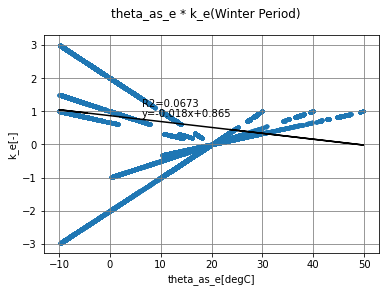

In [8]:
setPltSingle(df = df_winter,
       fig_title = "theta_as_e * k_e(Winter Period)",
       x_label = "theta_as_e[degC]",
       y_label = "k_e[-]", 
       x_data_name = "theta_as_e",
       y_data_name = "k_e"
      )

#### 相当外気温度と室温の差と補正係数

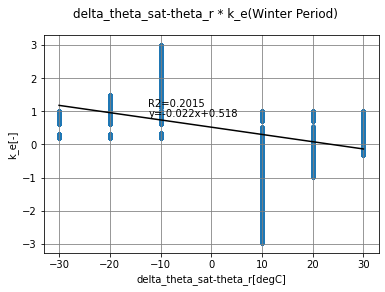

In [9]:
setPltSingle(df = df_winter,
       fig_title = "delta_theta_sat-theta_r * k_e(Winter Period)",
       x_label = "delta_theta_sat-theta_r[degC]",
       y_label = "k_e[-]", 
       x_data_name = "delta_theta_sat-theta_r",
       y_data_name = "k_e"
      )

#### 相当外気温度と室温の差と室内側表面熱流

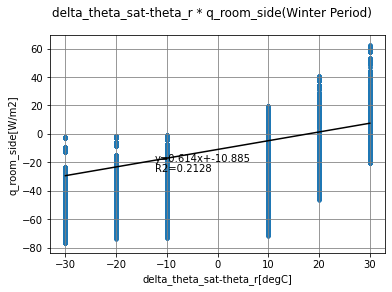

In [10]:
setPltSingle(df = df_winter,
       fig_title = "delta_theta_sat-theta_r * q_room_side(Winter Period)",
       x_label = "delta_theta_sat-theta_r[degC]",
       y_label = "q_room_side[W/m2]", 
       x_data_name = "delta_theta_sat-theta_r",
       y_data_name = "q_room_side"
      )

#### 相当外気温度と通気層の等価温度

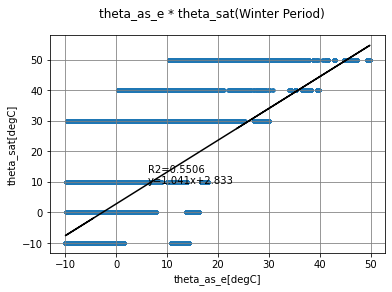

In [11]:
setPltSingle(df = df_winter,
       fig_title = "theta_as_e * theta_sat(Winter Period)",
       x_label = "theta_as_e[degC]",
       y_label = "theta_sat[degC]", 
       x_data_name = "theta_as_e",
       y_data_name = "theta_sat"
      )

### 夏期条件
#### 通気層の等価温度と補正係数

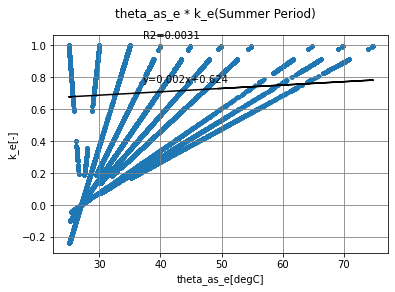

In [12]:
setPltSingle(df = df_summer,
       fig_title = "theta_as_e * k_e(Summer Period)",
       x_label = "theta_as_e[degC]",
       y_label = "k_e[-]", 
       x_data_name = "theta_as_e",
       y_data_name = "k_e"
      )

#### 相当外気温度と室温の差と補正係数

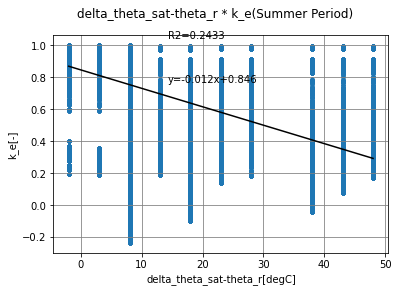

In [13]:
setPltSingle(df = df_summer,
       fig_title = "delta_theta_sat-theta_r * k_e(Summer Period)",
       x_label = "delta_theta_sat-theta_r[degC]",
       y_label = "k_e[-]", 
       x_data_name = "delta_theta_sat-theta_r",
       y_data_name = "k_e"
      )

#### 相当外気温度と室温の差と室内側表面熱流

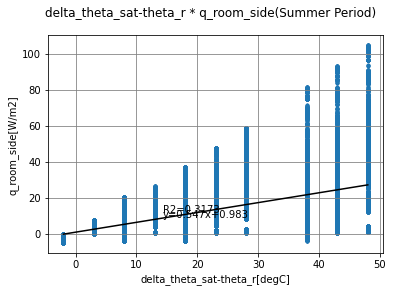

In [14]:
setPltSingle(df = df_summer,
       fig_title = "delta_theta_sat-theta_r * q_room_side(Summer Period)",
       x_label = "delta_theta_sat-theta_r[degC]",
       y_label = "q_room_side[W/m2]", 
       x_data_name = "delta_theta_sat-theta_r",
       y_data_name = "q_room_side"
      )

#### 相当外気温度と通気層の等価温度

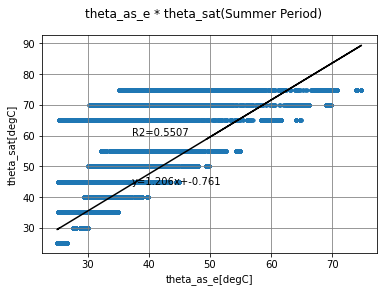

In [15]:
setPltSingle(df = df_summer,
       fig_title = "theta_as_e * theta_sat(Summer Period)",
       x_label = "theta_as_e[degC]",
       y_label = "theta_sat[degC]", 
       x_data_name = "theta_as_e",
       y_data_name = "theta_sat"
      )